# Python-executable version of PathView Graphs for ARC single BCR & parallel BCRs with shutdown event models

Runs two ARC-class fuel cycle residence time models:
 1) with a single 3m high BCR as the TES, and the BCR shutting down between days 2-3.
 2) with 2 x 3m high BCRs in parallel as the TES, with one BCR shutting down between days 2-3.

Expect script to take around 60 minutes to run.

If both results files already present, can skip to running plotting cell.

In [1]:
import concurrent.futures
from pathview_python_code import arc_single_bcr_shutdown, arc_parallel_bcrs_shutdown

# Duration for simulations
duration = 5 * 24 * 3600  # 5 days in seconds

print(f"Starting simulations in parallel (duration: {duration/(24*3600):.1f} days)...")

# Use ProcessPoolExecutor to run simulations in parallel using multiple CPU cores
with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
    # Submit both simulation tasks to the pool
    future_single = executor.submit(arc_single_bcr_shutdown, duration)
    future_series = executor.submit(arc_parallel_bcrs_shutdown, duration)

    # Wait for both simulations to finish
    concurrent.futures.wait([future_single, future_series])

print("Both simulations finished successfully!")

Starting simulations in parallel (duration: 5.0 days)...
09:47:18 - INFO - LOGGING (log: True)
09:47:18 - INFO - BLOCKS (total: 50, dynamic: 10, static: 40, eventful: 1)
09:47:18 - INFO - GRAPH (nodes: 50, edges: 78, alg. depth: 7, loop depth: 0, runtime: 3.938ms)
09:47:18 - INFO - STARTING -> TRANSIENT (Duration: 432000.00s)
09:47:18 - INFO - LOGGING (log: True)
09:47:18 - INFO - BLOCKS (total: 41, dynamic: 10, static: 31, eventful: 1)
09:47:18 - INFO - GRAPH (nodes: 41, edges: 62, alg. depth: 7, loop depth: 0, runtime: 0.784ms)
09:47:18 - INFO - STARTING -> TRANSIENT (Duration: 432000.00s)
c_T_in:  0.0001237010781998846
y_T2_in : 0.0
flow_l:  280.0
flow_g:  0.095
c_T_in:  0.0001237010781998846
y_T2_in : 0.0
flow_l:  560.0
flow_g:  0.19
c_T_in:  0.0001237010781998846
y_T2_in : 0.0
flow_l:  280.0
flow_g:  0.095
c_T_in:  0.0001237010781998846
y_T2_in : 0.0
flow_l:  560.0
flow_g:  0.19
c_T_in:  0.0001237010781998846
y_T2_in : 0.0
flow_l:  280.0
flow_g:  0.095
c_T_in:  0.00012370107819988

Plot saved to: ../plots/ARC_single_vs_parallel_bcr_shutdown_Fig6.png
Plot saved to: ../plots/ARC_single_vs_parallel_bcr_shutdown_Fig6.pdf


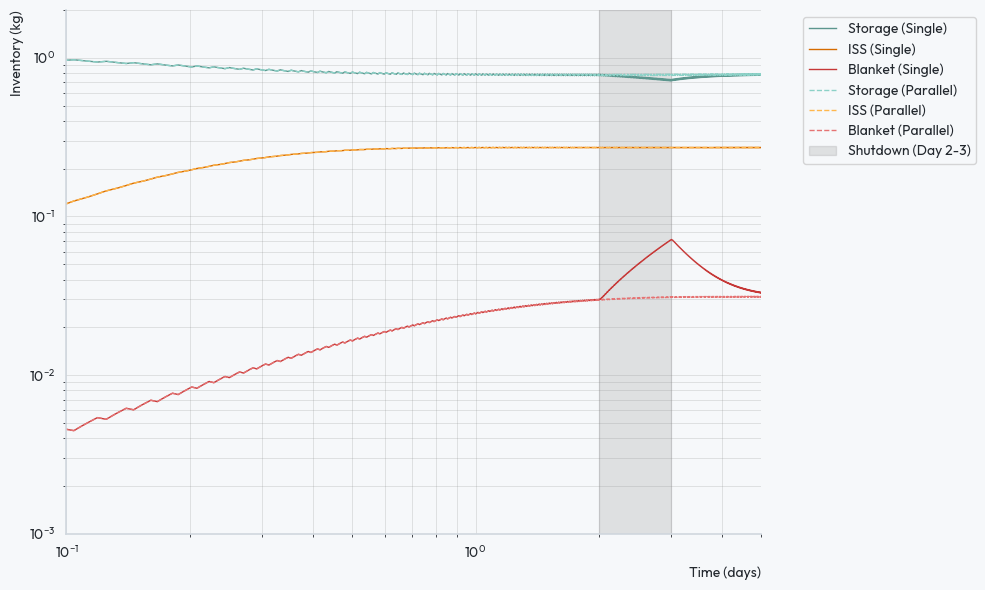

In [12]:
# Plot Storage, Blanket & ISS inventories vs time for both simulations on the same plot. Highlight the shutdown period.
import numpy as np
import matplotlib.pyplot as plt
import morethemes as mt
import os

# Load results
single_res = np.load('../results/ARC_single_bcr_shutdown_results.npz')
parallel_res = np.load('../results/ARC_parallel_bcrs_shutdown_results.npz')

def get_data(results):
    # Find keys based on labels in the key name
    inner_key = next(k for k in results.files if 'Storage' in k and 'data' in k)
    outer_key = next(k for k in results.files if 'Blanket' in k and 'data' in k)
    time_key = inner_key.replace('data', 'time')
    
    time = results[time_key] / (24 * 3600)
    # Inner scope labels: ["Storage","Pump","ISS","Cleanup","Detritiation"]
    storage = results[inner_key][0]
    iss = results[inner_key][2]
    # Outer scope labels: ["Divertor","FW","Blanket","HX"]
    blanket = results[outer_key][2]
    
    return time, storage, iss, blanket

t_s, storage_s, iss_s, blanket_s = get_data(single_res)
t_p, storage_p, iss_p, blanket_p = get_data(parallel_res)

mt.set_theme("lighter")
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors
# Single BCR (Solid, Saturated)
c_storage_s = '#5c968e'  # Darker teal
c_iss_s = '#d66b00'      # Darker orange
c_blanket_s = '#c63837'  # Darker red

# Parallel BCRs (Dashed, Lighter)
c_storage_p = '#8CD1C7'  # Lighter teal
c_iss_p = '#FFB74D'      # Lighter orange
c_blanket_p = '#E57373'  # Lighter red
c_shutdown = 'grey'

# Plot Single BCR (Solid lines, Thicker)
ax.plot(t_s, storage_s, color=c_storage_s, linestyle='-', linewidth=1, label='Storage (Single)')
ax.plot(t_s, iss_s, color=c_iss_s, linestyle='-', linewidth=1, label='ISS (Single)')
ax.plot(t_s, blanket_s, color=c_blanket_s, linestyle='-', linewidth=1, label='Blanket (Single)')

# Plot Parallel BCRs (Dashed lines, Thinner, Lighter)
ax.plot(t_p, storage_p, color=c_storage_p, linestyle='--', linewidth=1, label='Storage (Parallel)')
ax.plot(t_p, iss_p, color=c_iss_p, linestyle='--', linewidth=1, label='ISS (Parallel)')
ax.plot(t_p, blanket_p, color=c_blanket_p, linestyle='--', linewidth=1, label='Blanket (Parallel)')

# Highlight Shutdown Period
ax.axvspan(2, 3, color=c_shutdown, alpha=0.2, label='Shutdown (Day 2-3)')

# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 5)
ax.set_ylim(1e-3, 2)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Inventory (kg)')
ax.grid(True, which='both', alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save plot to plots folder
plots_dir = '../plots'
os.makedirs(plots_dir, exist_ok=True)
plot_filename = 'ARC_single_vs_parallel_bcr_shutdown_Fig6.png'
plot_path = os.path.join(plots_dir, plot_filename)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {plot_path}")

# Save as PDF
pdf_filename = 'ARC_single_vs_parallel_bcr_shutdown_Fig6.pdf'
pdf_path = os.path.join(plots_dir, pdf_filename)
plt.savefig(pdf_path, bbox_inches='tight')
print(f"Plot saved to: {pdf_path}")

plt.show()